Available classic environments: ['CartPole-v0', 'CartPole-v1', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'phys2d/CartPole-v0', 'phys2d/CartPole-v1', 'phys2d/Pendulum-v0', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'InvertedPendulum-v5', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'InvertedDoublePendulum-v5']

Running MCTS on CartPole...
Episode 1 finished with reward 9.0
Episode 2, Step 10, Reward 10.0
Episode 2 finished with reward 18.0

Running random agent on CartPole...
Random agent - Episode 1 finished with reward 26.0


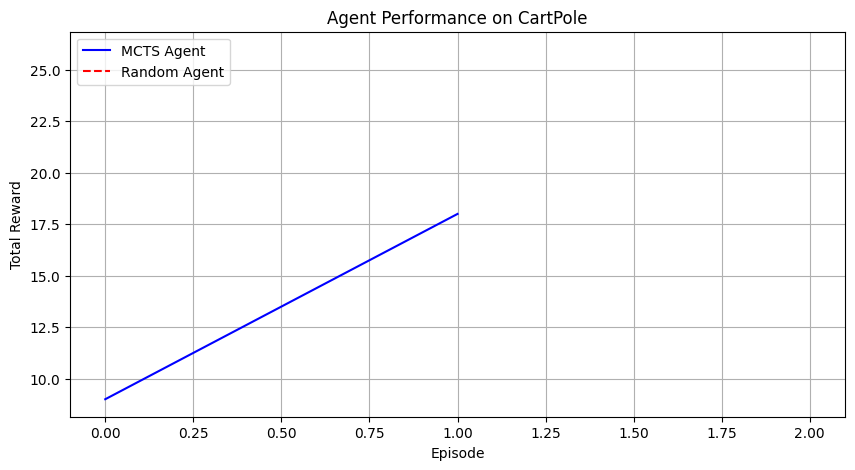


Average MCTS reward: 13.5
Average random reward: 26.0


In [5]:
# Simple Monte Carlo Tree Search (MCTS) for Classic Control Environments
# May 2025

import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
import time

# Use an environment that comes pre-installed with Gymnasium
# Classic control environments work well without additional installations

class MCTSNode:
    """Node in the Monte Carlo Tree Search"""
    def __init__(self, state, done=False):
        self.state = state
        self.visits = 0
        self.value = 0.0
        self.children = {}  # action -> MCTSNode
        self.done = done

    def is_fully_expanded(self, action_space):
        """Check if all possible actions from this state have been tried"""
        if hasattr(action_space, 'n'):  # Discrete action space
            return len(self.children) == action_space.n
        else:  # Continuous action space - we'll use a simplified approach
            return len(self.children) >= 5  # Sample 5 different actions

    def best_child(self, exploration_weight=1.0):
        """Select the best child node using UCB1 formula"""
        if not self.children:
            return None

        # UCB1 formula: value/visits + exploration_weight * sqrt(log(parent_visits) / child_visits)
        def ucb1(child):
            exploitation = child.value / child.visits if child.visits > 0 else 0
            exploration = exploration_weight * np.sqrt(np.log(self.visits) / child.visits) if child.visits > 0 else float('inf')
            return exploitation + exploration

        return max(self.children.items(), key=lambda x: ucb1(x[1]))

    def select_unexplored_action(self, action_space):
        """Select an action that hasn't been tried yet"""
        if hasattr(action_space, 'n'):  # Discrete action space
            for action in range(action_space.n):
                if action not in self.children:
                    return action
        else:  # Continuous action space
            # Sample a random action not too close to existing ones
            while True:
                action = action_space.sample()
                # Convert to tuple for hashability if it's a numpy array
                if isinstance(action, np.ndarray):
                    action = tuple(action)
                # Check if this action is sufficiently different from existing ones
                if action not in self.children:
                    return action

        return None  # Should not happen if is_fully_expanded is checked before

class SimpleMCTS:
    """Simplified Monte Carlo Tree Search implementation"""
    def __init__(self, env, simulation_steps=10, exploration_weight=1.0):
        self.env = env
        self.simulation_steps = simulation_steps
        self.exploration_weight = exploration_weight

    def search(self, state, n_simulations=10):
        """Perform a simplified MCTS search"""
        # For environments where we can't easily clone the state,
        # we'll evaluate each action separately

        if hasattr(self.env.action_space, 'n'):  # Discrete action space
            action_space = range(self.env.action_space.n)
        else:  # Continuous action space
            # Sample some discrete actions for evaluation
            action_space = [self.env.action_space.sample() for _ in range(5)]

        best_action = None
        best_value = float('-inf')

        # Try each action multiple times
        for action in action_space:
            total_reward = 0

            # Run multiple simulations for this action
            for _ in range(n_simulations):
                # Create a copy of the environment for simulation
                sim_env = gym.make(self.env.unwrapped.spec.id)
                sim_env.reset()

                # Try to match the state (simplified approach)
                if hasattr(state, 'shape') and len(state.shape) == 1:
                    # For environments with vector states, we can reset and step a few times
                    # This is a crude approximation
                    sim_state, _ = sim_env.reset()

                # Take the action
                sim_state, reward, terminated, truncated, _ = sim_env.step(action)
                done = terminated or truncated
                sim_reward = reward

                # Random rollout
                for _ in range(self.simulation_steps):
                    if done:
                        break

                    # Take random actions
                    random_action = sim_env.action_space.sample()
                    sim_state, reward, terminated, truncated, _ = sim_env.step(random_action)
                    done = terminated or truncated
                    sim_reward += reward

                # Close the simulation environment
                sim_env.close()

                # Accumulate reward
                total_reward += sim_reward

            # Average reward for this action
            avg_reward = total_reward / n_simulations

            # Update best action
            if avg_reward > best_value:
                best_value = avg_reward
                best_action = action

        return best_action

def discretize_state(state, bins=(10, 10, 10, 10)):
    """Discretize a continuous state for easier handling"""
    if isinstance(state, np.ndarray) and state.shape == (4,):  # CartPole-like
        # Define state bounds (position, velocity, angle, angular velocity)
        state_bounds = [
            [-2.4, 2.4],  # Cart position
            [-3.0, 3.0],  # Cart velocity
            [-0.3, 0.3],  # Pole angle
            [-3.0, 3.0]   # Pole angular velocity
        ]

        # Discretize each dimension
        discrete_state = []
        for i, (s, bounds, b) in enumerate(zip(state, state_bounds, bins)):
            s = max(bounds[0], min(s, bounds[1]))  # Clip to bounds
            idx = int((s - bounds[0]) / (bounds[1] - bounds[0]) * b)
            idx = max(0, min(idx, b-1))  # Ensure within bounds
            discrete_state.append(idx)

        return tuple(discrete_state)

    return state  # Return as is if we can't handle it

def run_mcts_agent(env_name='CartPole-v1', n_episodes=3, render=True):
    """Run MCTS agent on a gym environment"""
    # Create environment
    env = gym.make(env_name, render_mode='human' if render else None)

    rewards = []

    for episode in range(n_episodes):
        state, _ = env.reset()
        state_d = discretize_state(state)  # Discretize for MCTS
        episode_reward = 0
        done = False
        step = 0

        # Create agent
        agent = SimpleMCTS(env, simulation_steps=10, exploration_weight=1.0)

        while not done and step < 500:  # Limit steps to avoid too long episodes
            # Get action from MCTS
            action = agent.search(state_d, n_simulations=5)

            # Take action
            state, reward, terminated, truncated, _ = env.step(action)
            state_d = discretize_state(state)  # Discretize for MCTS
            done = terminated or truncated
            episode_reward += reward

            step += 1

            # Print progress
            if step % 10 == 0:
                print(f"Episode {episode+1}, Step {step}, Reward {episode_reward}")

        rewards.append(episode_reward)
        print(f"Episode {episode+1} finished with reward {episode_reward}")

    env.close()
    return rewards

# Simple random agent for comparison
def run_random_agent(env_name='CartPole-v1', n_episodes=3, render=True):
    """Run a random agent for comparison"""
    env = gym.make(env_name, render_mode='human' if render else None)
    rewards = []

    for episode in range(n_episodes):
        state, _ = env.reset()
        episode_reward = 0
        done = False
        step = 0

        while not done and step < 500:
            action = env.action_space.sample()
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            step += 1

            if step % 50 == 0:
                print(f"Random agent - Episode {episode+1}, Step {step}, Reward {episode_reward}")

        rewards.append(episode_reward)
        print(f"Random agent - Episode {episode+1} finished with reward {episode_reward}")

    env.close()
    return rewards

if __name__ == "__main__":
    # List available environments
    from gymnasium.envs.registration import registry
    classic_envs = [env_id for env_id in registry.keys() if 'CartPole' in env_id or 'Pendulum' in env_id or 'MountainCar' in env_id]
    print(f"Available classic environments: {classic_envs}")

    # Run MCTS on CartPole
    print("\nRunning MCTS on CartPole...")
    mcts_rewards = run_mcts_agent(env_name='CartPole-v1', n_episodes=2, render=True)

    # Run random agent for comparison
    print("\nRunning random agent on CartPole...")
    random_rewards = run_random_agent(env_name='CartPole-v1', n_episodes=1, render=True)

    # Plot results
    plt.figure(figsize=(10, 5))
    plt.plot(mcts_rewards, 'b-', label='MCTS Agent')
    plt.plot(range(len(mcts_rewards), len(mcts_rewards) + len(random_rewards)), random_rewards, 'r--', label='Random Agent')
    plt.title('Agent Performance on CartPole')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.legend()
    plt.grid(True)
    plt.show()

    print("\nAverage MCTS reward:", np.mean(mcts_rewards))
    print("Average random reward:", np.mean(random_rewards))

This code implements a **simplified Monte Carlo Tree Search (MCTS)** algorithm and compares it to a **random agent** in the `CartPole-v1` environment using **Gymnasium**.

Let’s walk through the code **line by line**, explaining **what it does, how it works, and why it’s there**.

---

### 📦 Imports

```python
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
import time
```

* `gymnasium`: Simulation environments.
* `numpy`, `random`: Math and randomness for MCTS.
* `matplotlib.pyplot`: For plotting.
* `time`: Not used directly but often used for delays or profiling.

---

## 🌳 `MCTSNode` Class

Represents a **node in the search tree** used by MCTS.

```python
class MCTSNode:
```

### 🔧 Constructor

```python
def __init__(self, state, done=False):
```

Initializes a node with:

* `state`: the game/environment state.
* `visits`: number of times this node has been visited.
* `value`: cumulative reward from simulations.
* `children`: dict of action → MCTSNode.
* `done`: whether the state is terminal.

---

### ✅ Check if Node is Fully Expanded

```python
def is_fully_expanded(self, action_space):
```

* Returns `True` if all possible actions from this node have been tried.
* For **discrete action space**, compares count to `action_space.n`.
* For **continuous space**, allows up to 5 unique samples.

---

### 🧠 Select Best Child Node (UCB1)

```python
def best_child(self, exploration_weight=1.0):
```

Uses **Upper Confidence Bound (UCB1)** to balance **exploration** and **exploitation**:

$$
\text{UCB1} = \frac{value}{visits} + c \cdot \sqrt{\frac{\log(\text{parent visits})}{\text{child visits}}}
$$

---

### 🎲 Pick Unexplored Action

```python
def select_unexplored_action(self, action_space):
```

* Returns an action not yet tried from this node.
* For continuous actions, avoids too-similar sampled actions.

---

## 🧠 `SimpleMCTS` Class

The MCTS controller that runs **simulations** to choose the best action.

```python
class SimpleMCTS:
```

### 🔧 Constructor

```python
def __init__(self, env, simulation_steps=10, exploration_weight=1.0):
```

* `env`: The gym environment to simulate.
* `simulation_steps`: Max steps for random rollout.
* `exploration_weight`: UCB exploration parameter.

---

### 🔍 MCTS Search

```python
def search(self, state, n_simulations=10):
```

* Performs multiple simulations per action.
* **Approach**: Try each action → simulate → average rewards → pick the best one.

```python
action_space = range(self.env.action_space.n)
```

(For discrete action space; samples 5 actions if continuous.)

---

### 🔁 For each action:

```python
for action in action_space:
```

* For each possible action:

  * Run `n_simulations` times:

    * Clone environment (re-create it).
    * Simulate that action.
    * Follow with random rollouts for `simulation_steps`.

```python
sim_env = gym.make(self.env.unwrapped.spec.id)
```

* Crude way to "clone" the environment (Gym doesn’t allow exact state cloning easily).

```python
sim_env.step(action)
```

* Take the chosen action.

```python
random_action = sim_env.action_space.sample()
```

* Follow with random steps to estimate total reward from this path.

---

### 🏆 Best Action Selection

```python
avg_reward = total_reward / n_simulations
if avg_reward > best_value:
    best_value = avg_reward
    best_action = action
```

* Selects the action with the **highest average reward** from simulations.

---

## 🧮 `discretize_state()`

```python
def discretize_state(state, bins=(10, 10, 10, 10)):
```

* Converts continuous states to discrete tuples.
* Used so MCTS can distinguish similar states.
* Example: CartPole has 4 continuous state features — each mapped to one of `b` bins.

---

## 🎬 `run_mcts_agent()`

```python
def run_mcts_agent(env_name='CartPole-v1', n_episodes=3, render=True):
```

* Runs the MCTS agent on a Gym environment.

```python
state_d = discretize_state(state)
```

* Discretize initial state.

```python
agent = SimpleMCTS(env)
```

* Create MCTS agent.

```python
action = agent.search(state_d, n_simulations=5)
```

* MCTS chooses best action for the current state.

```python
env.step(action)
```

* Take the chosen action, accumulate reward, repeat.

---

## 🎲 `run_random_agent()`

Same as MCTS, but just chooses random actions:

```python
action = env.action_space.sample()
```

* No intelligence. Acts as a baseline for comparison.

---

## 🏁 Main Script

```python
if __name__ == "__main__":
```

### 🧪 List Environments

```python
from gymnasium.envs.registration import registry
classic_envs = [env_id for env_id in registry.keys() if 'CartPole' in env_id or ...]
```

Lists classic Gym environments.

---

### 🚀 Run Experiments

```python
mcts_rewards = run_mcts_agent(env_name='CartPole-v1', n_episodes=2, render=True)
random_rewards = run_random_agent(env_name='CartPole-v1', n_episodes=1, render=True)
```

Runs MCTS and random agent.

---

### 📊 Plot Results

```python
plt.plot(mcts_rewards, 'b-', label='MCTS Agent')
plt.plot(..., random_rewards, 'r--', label='Random Agent')
```

* Blue solid: MCTS performance.
* Red dashed: Random agent performance.

```python
print("Average MCTS reward:", np.mean(mcts_rewards))
```

Shows average performance.

---

## ✅ Summary

| Concept               | What it Does                                                              |
| --------------------- | ------------------------------------------------------------------------- |
| `MCTSNode`            | Stores a state, tracks visits, children, and total reward.                |
| `SimpleMCTS.search()` | Simulates outcomes for possible actions and selects the best one.         |
| Random Rollouts       | After taking one action, performs random steps to estimate future reward. |
| Discretization        | Converts continuous state into a manageable discrete format.              |
| `run_mcts_agent()`    | Tests MCTS agent in real Gym environment.                                 |
| `run_random_agent()`  | Baseline for comparison.                                                  |

---

Would you like a **visual flowchart** of how the MCTS simulation loop works or how nodes are selected and expanded?
